## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [1]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [2]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.8 MB/s eta 0:00:00:00:0100:01


In [8]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('/kaggle/input/deeplearning/xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [9]:
import json
# Load database

json_file = '/kaggle/input/deeplearning/xview_recognition/xview_ann_train.json' 
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [10]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [11]:
from sklearn.model_selection import train_test_split

labels = [image.objects[0].category for image in anns]
anns_train, anns_valid = train_test_split(anns, test_size=0.12, random_state=1, shuffle=True, stratify=labels)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 18811
Number of validation images: 2566


In [13]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
print('Load model')


def build_model():
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))  # Flatten the input
    
    # Balanced depth and width layers
    model.add(Dense(1024))  # First dense layer with 1024 units
    model.add(LeakyReLU(negative_slope=0.2))  # Leaky ReLU activation with negative_slope=0.2
    model.add(Dense(512))  # Second dense layer with 512 units
    model.add(LeakyReLU(negative_slope=0.15))  # Leaky ReLU activation with negative_slope=0.15
    model.add(Dense(256))  # Third dense layer with 256 units
    model.add(LeakyReLU(negative_slope=0.1))  # Leaky ReLU activation with negative_slope=0.1
    model.add(Dense(128))  # Fourth dense layer with 128 units
    model.add(LeakyReLU(negative_slope=0.05))  # Leaky ReLU activation with negative_slope=0.05
    
    model.add(Dense(len(categories)))  # Output layer with as many units as the categories
    model.add(Activation('softmax'))  # Softmax activation for multi-class classification

    
   # Learning rate is changed to 0.001
    opt = Adam(learning_rate=1e-3, beta_1=0.85, beta_2=0.995, epsilon=1e-7, amsgrad=True, clipnorm=0.5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

strategy = tf.distribute.MirroredStrategy() # Strategy for multi gpu usage
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()
    
multi_gpu_model.summary()

Load model
Number of devices: 2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │     154,141,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 12)                  │           1,548 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 12)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,832,268 (590.64 MB)

 Trainable params: 154,832,268 (590.64 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [15]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [16]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 256
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [17]:

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17359008891609351573
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6112401711741234224
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14117103693719113055
 physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
 xla_global_id: 2144165316]

In [18]:
import math
import numpy as np

print('Training model')
epochs = 50
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)

with tf.device("/device:GPU:0"):
    h = multi_gpu_model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1177 - loss: 16006.3984
Epoch 1: val_accuracy improved from -inf to 0.12783, saving model to model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 700s 10s/step - accuracy: 0.1179 - loss: 15939.0039 - val_accuracy: 0.1278 - val_loss: 5565.6304 - learning_rate: 0.0010
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1301 - loss: 3573.3083
Epoch 2: val_accuracy did not improve from 0.12783
74/74 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1301 - loss: 3561.8538 - val_accuracy: 0.0678 - val_loss: 3908.9714 - learning_rate: 0.0010
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1384 - loss: 1819.6888
Epoch 3: val_accuracy improved from 0.12783 to 0.21980, saving model to model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.1385 - loss: 1810.1198 - val_accuracy: 0.2198 - val_loss: 234.3581 - learning_rate: 0.0010
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.1593 - 

#### Validation
Compute validation metrics.

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [21]:
import numpy as np
model = multi_gpu_model
multi_gpu_model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

<ipython-input-20-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


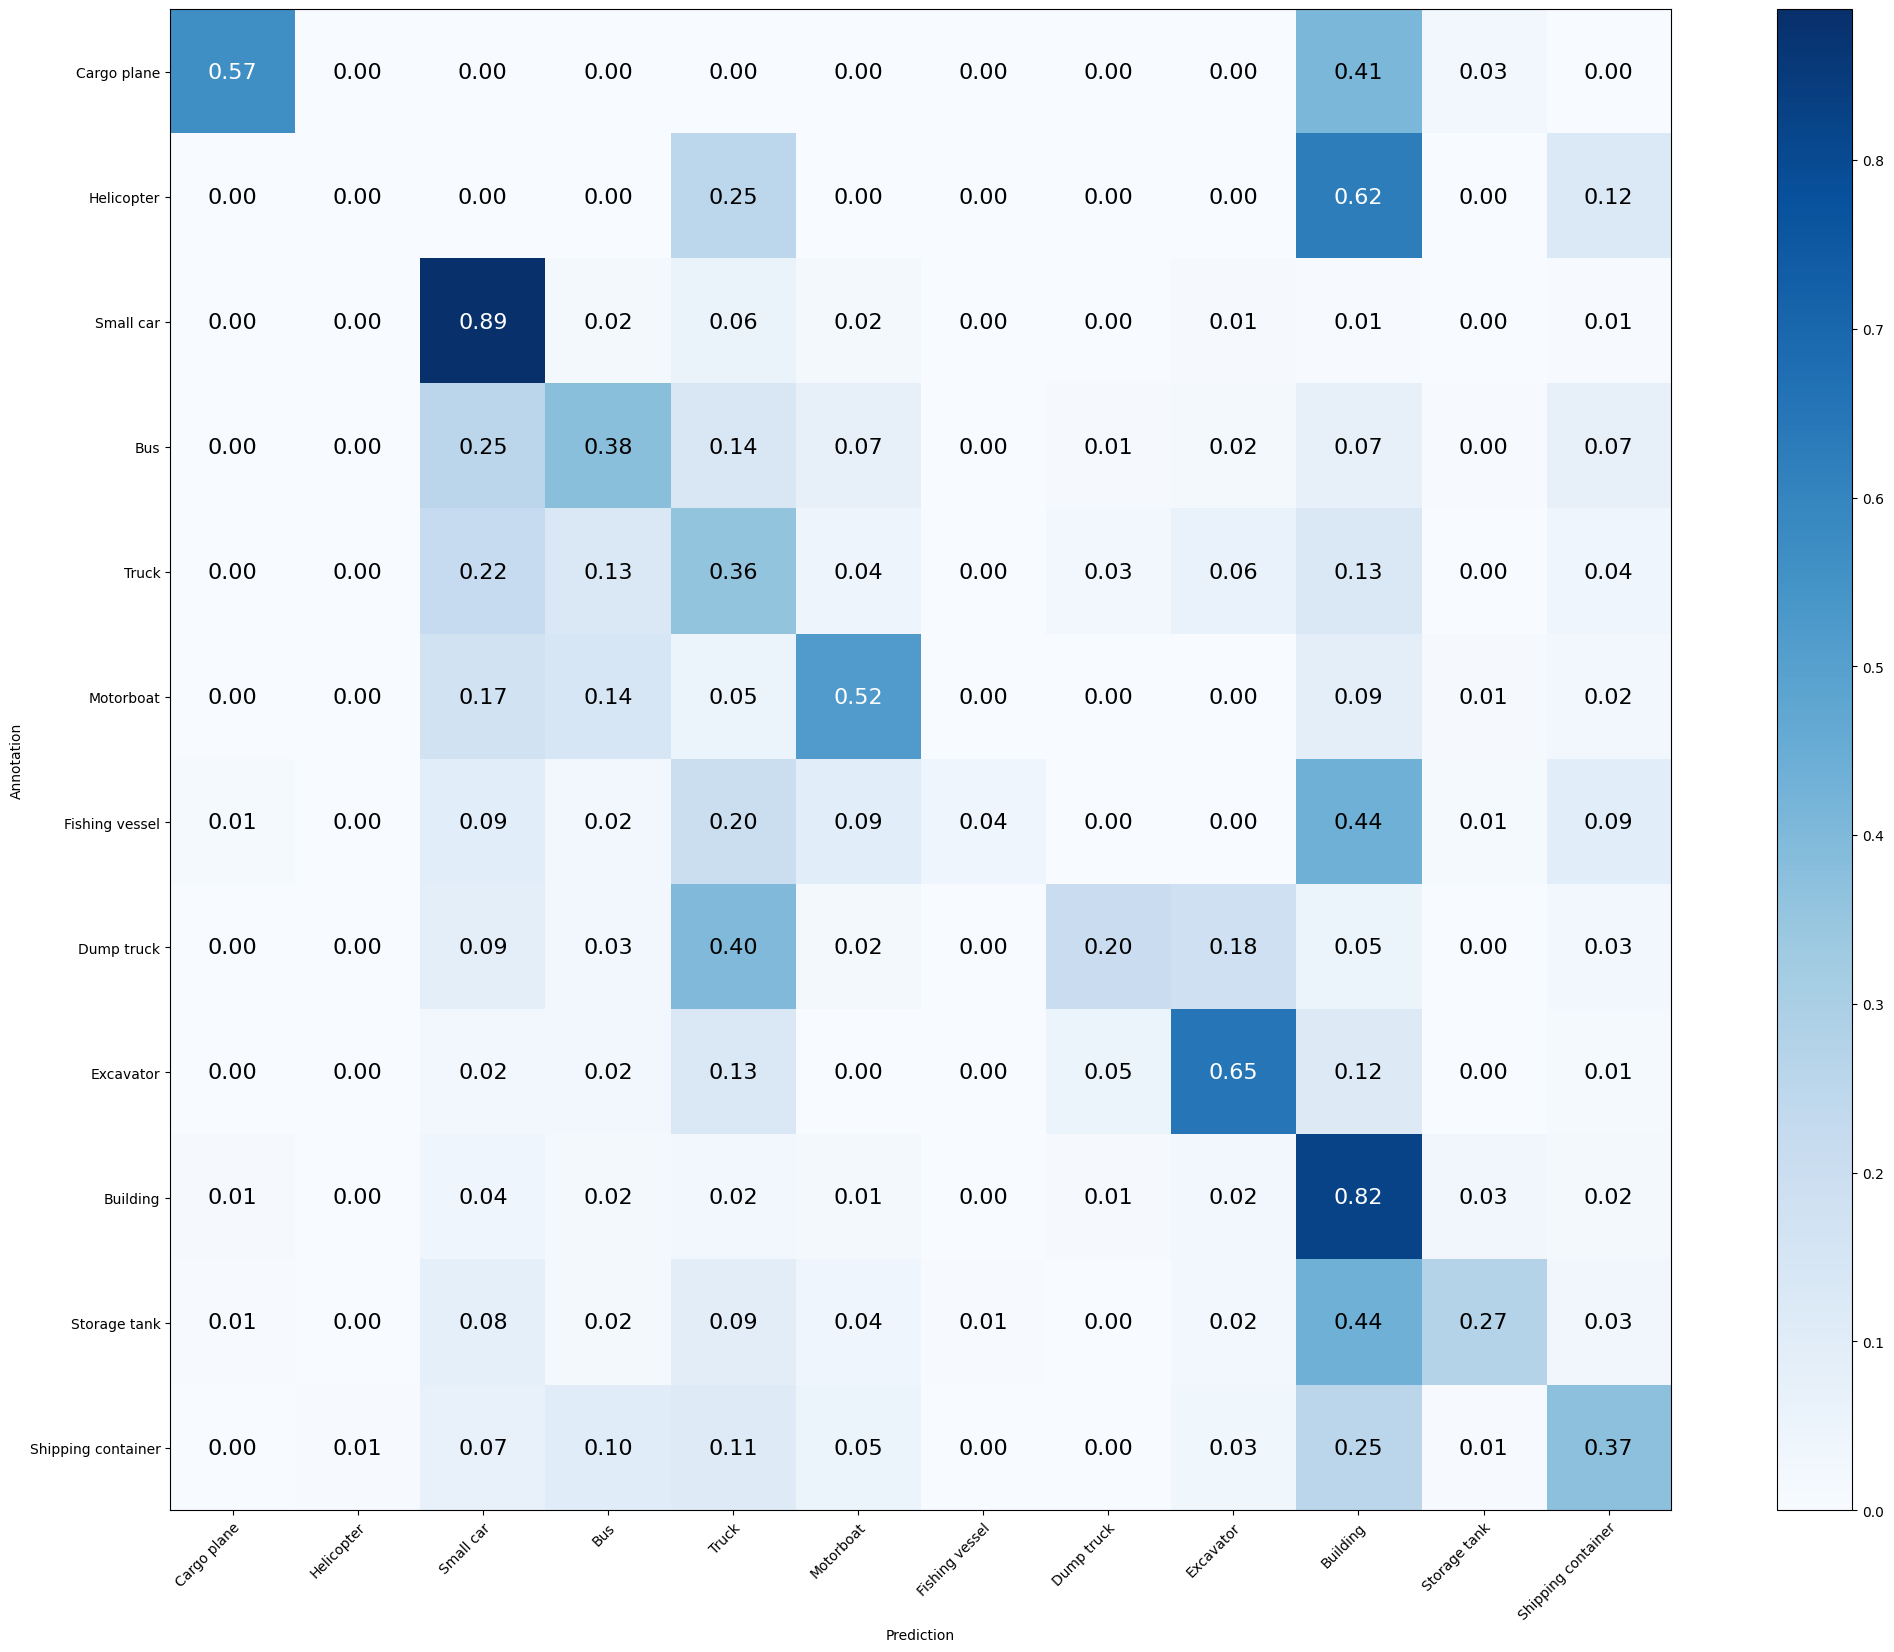

In [22]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

results = h.history

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot Accuracy
axes[0].plot(results["accuracy"], label="Training Accuracy", color="blue")
axes[0].plot(results["val_accuracy"], label="Validation Accuracy", color="green")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy Over Epochs")
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0, 1)  # Normalize y-axis for accuracy (0-1 range)

# Plot Loss
axes[1].plot(results["loss"], label="Training Loss", color="red")
axes[1].plot(results["val_loss"], label="Validation Loss", color="orange")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss Over Epochs")
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0, max(max(results["loss"]), max(results["val_loss"])) * 1.1)  # Normalize loss y-axis

plt.xlabel("Epochs")
plt.tight_layout()

plt.savefig("/kaggle/working/plot.png", format="png", bbox_inches="tight")
plt.close()

In [23]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 56.742%
Mean Recall: 42.185%
Mean Precision: 52.299%
> Cargo plane: Recall: 56.579% Precision: 86.000% Specificity: 99.719% Dice: 68.254%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 99.961% Dice: 0.000%
> Small car: Recall: 88.932% Precision: 66.473% Specificity: 88.737% Dice: 76.080%
> Bus: Recall: 37.838% Precision: 47.115% Specificity: 95.232% Dice: 41.970%
> Truck: Recall: 35.758% Precision: 36.086% Specificity: 90.653% Dice: 35.921%
> Motorboat: Recall: 51.562% Precision: 46.479% Specificity: 96.883% Dice: 48.889%
> Fishing vessel: Recall: 3.529% Precision: 60.000% Specificity: 99.919% Dice: 6.667%
> Dump truck: Recall: 20.270% Precision: 60.000% Specificity: 99.173% Dice: 30.303%
> Excavator: Recall: 65.263% Precision: 44.604% Specificity: 96.884% Dice: 52.991%
> Building: Recall: 82.060% Precision: 61.518% Specificity: 85.572% Dice: 70.320%
> Storage tank: Recall: 27.273% Precision: 68.571% Specificity: 99.079% Dice: 39.024%
> Shipping container: R

#### Testing
Try to improve the results provided in the competition.

In [24]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/deeplearning/xview_recognition/xview_test'):
#for (dirpath, dirnames, filenames) in os.walk('xview_recognition/xview_test'):
    
    for filename in filenames:
        #image = GenericImage(dirpath[18:]+'/'+filename)
        image = GenericImage('xview_test/'+filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2635


In [25]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [26]:
with open("/kaggle/working/prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)
#with open("prediction.json", "w") as outfile:
    #json.dump(predictions_data, outfile)